#  Прогнозирование заказов такси

## Описание проекта
Таксопарк хочет прогнозировать количество вызовов такси в аэропорты каждый час на базе исторических данных. 

## Задача
Построить модель предсказания в котором значение метрики RMSE будет меньше 48.

## Исходные данные
Данные находятся в файле taxi.csv, количество заказов находится в столбце num_orders.
1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Загрузка данных

Проведем настрйоки Jupyter Notebook (отключение предупреждений) и сделам импорт необходимых библиотек.

In [1]:
# Игнгорирование предупреждений системы
import warnings
warnings.filterwarnings("ignore")

In [2]:
!pip install -q statsmodels
!pip install -q lightgbm

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from lightgbm import LGBMRegressor

In [4]:
# отображаем все столбцы и до 100 строк
pd.options.display.max_columns = 250
pd.options.display.max_rows = 100
#pd.set_option('display.precision', 2)
pd.options.display.float_format = '{:20.2f}'.format

RANDOM_STATE = 42
TEST_SIZE = 0.1

Загрузим датасет и сделаем первичные выводы.

In [5]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', parse_dates=['datetime'], index_col=['datetime'])
df.sort_index(inplace=True)
print(df.head())
print(df.info())
print('Хронологически возрастает:', df.index.is_monotonic_increasing)
print('Пропуски:', df.isna().sum())
print('Диапазон дат: от', df.index.min(), 'до', df.index.max())

                     num_orders
datetime                       
2018-03-01 00:00:00           9
2018-03-01 00:10:00          14
2018-03-01 00:20:00          28
2018-03-01 00:30:00          20
2018-03-01 00:40:00          32
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
None
Хронологически возрастает: True
Пропуски: num_orders    0
dtype: int64
Диапазон дат: от 2018-03-01 00:00:00 до 2018-08-31 23:50:00


Выводы - загрузили данные. Всего представлено 26496 строк. Данные отсортированы по дате, данные обновляются каждые 10 минут. При загрузке сделали колонку с датой индексной, упорядочили данные по возрастанию индекса. Проверили, что дата и время идут в хронологическом ли порядке. Представлены данные за период с 1 марта по 31 августа 2018 года.

## Анализ временных рядов

Построим график распределения.

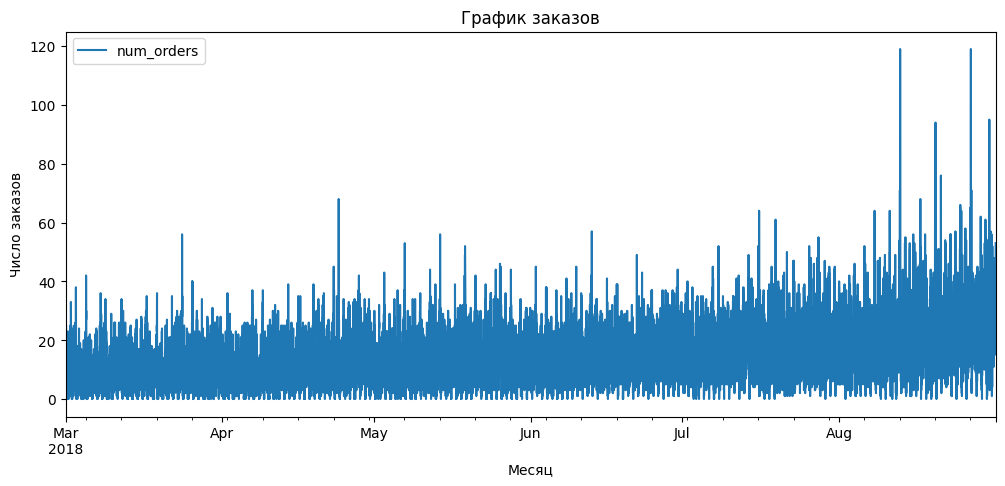

In [6]:
plt.rcParams["figure.figsize"] = (12,5)
df.plot(title='График заказов', xlabel='Месяц', ylabel='Число заказов')
plt.show()

График получился малоинформативный. Сделам ресемплирование с шагом 1 день и построим его заново. Добавим скользящее вреднее с отставанием на 1 день за 7 дней. И стандартное отклонение.

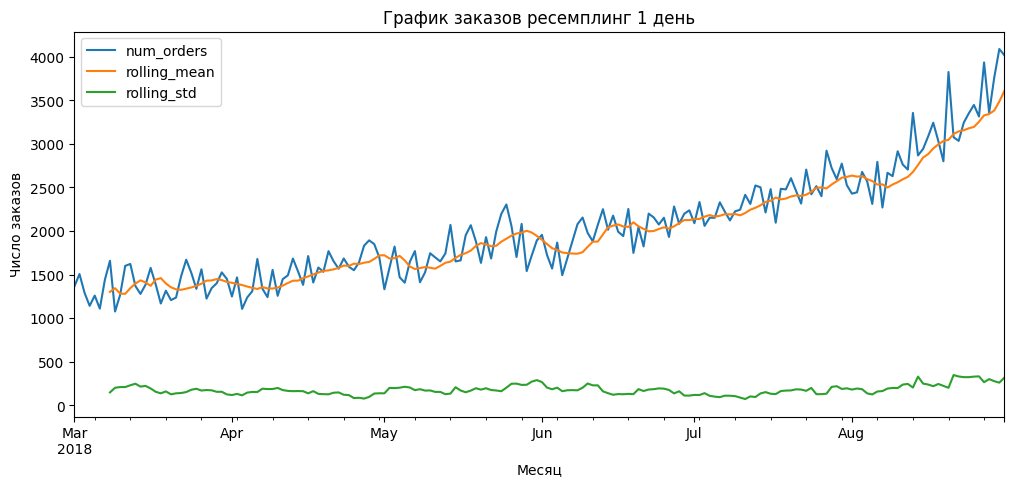

In [7]:
df1d = df.resample('1D').sum()
df1d['rolling_mean'] = df1d.shift().rolling(7).mean()
df1d['rolling_std'] = df1d.num_orders.shift().rolling(7).std()
df1d.plot(title='График заказов ресемплинг 1 день', xlabel='Месяц', ylabel='Число заказов');

И по месячно посмотрим среднее число заказов как оно меняется. Чтобы увидеть динамику заказом в масштабе 1 месяц, сделаем помесячное ресемплирование.

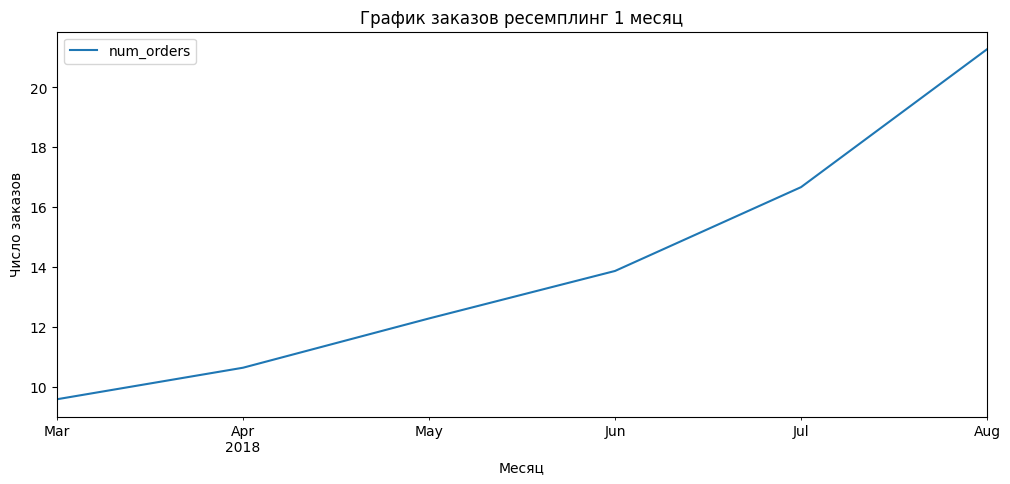

In [8]:
df1m = df.resample('1M').mean()
df1m.plot(title='График заказов ресемплинг 1 месяц', xlabel='Месяц', ylabel='Число заказов');

Выводы. Видно увеличение заказов с марта по август.

Для выявления сезонности и трендов с помощью decomposed раскладываем ряд значений на тренд, сезонность и остаточные значения ресемплированные данные по 1 дню.

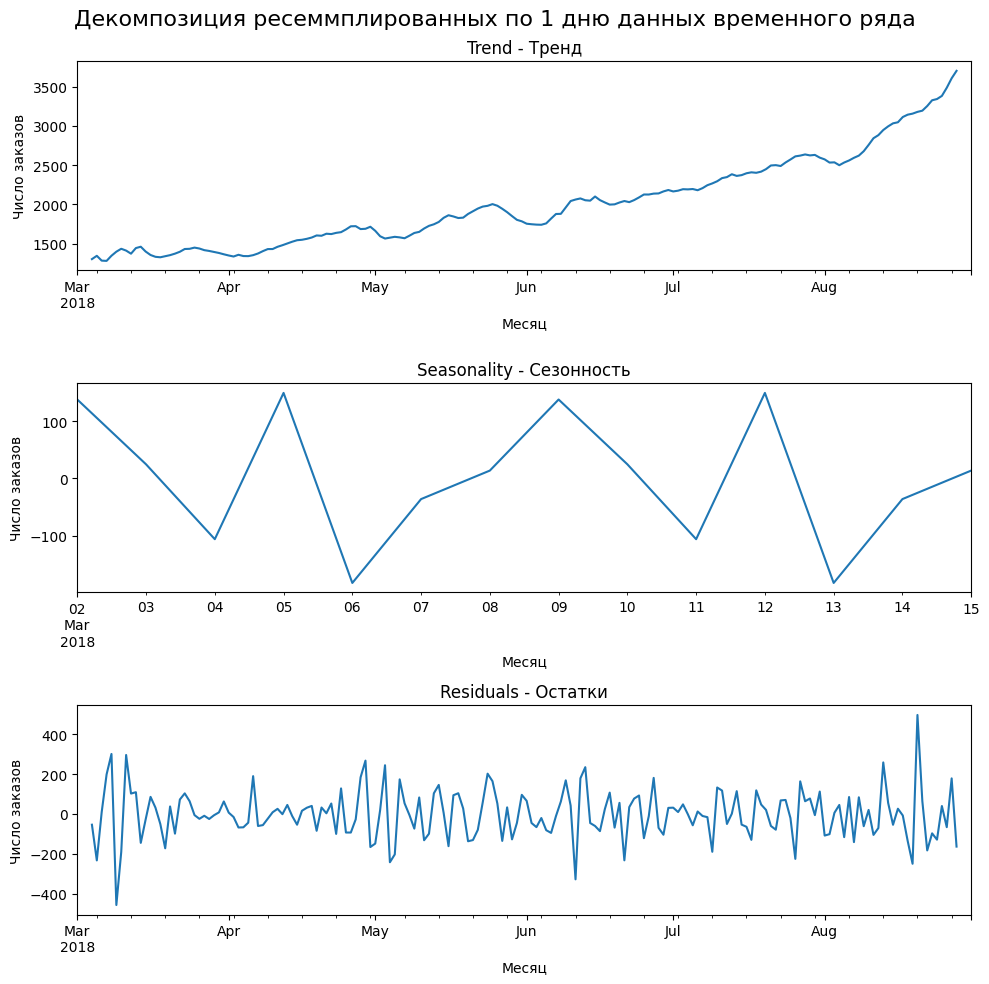

In [9]:
df1d = df.resample('1D').sum()
decomposed = seasonal_decompose(df1d)
plt.figure(figsize=(10, 10))
plt.suptitle('Декомпозиция ресеммплированных по 1 дню данных временного ряда', fontsize=16)
plt.subplot(311)
# Чтобы график корректно отобразился, указываем его
# оси ax, равными plt.gca() (англ. get current axis,
# получить текущие оси)
decomposed.trend.plot(ax=plt.gca(), xlabel='Месяц', ylabel='Число заказов')
plt.title('Trend - Тренд')

plt.subplot(312)
decomposed.seasonal[1:15].plot(ax=plt.gca(), xlabel='Месяц', ylabel='Число заказов') 
plt.title('Seasonality - Сезонность')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca(), xlabel='Месяц', ylabel='Число заказов')
plt.title('Residuals - Остатки')
plt.tight_layout()

Разложим на стотовляющие ресеммплированные данные по 1 часу

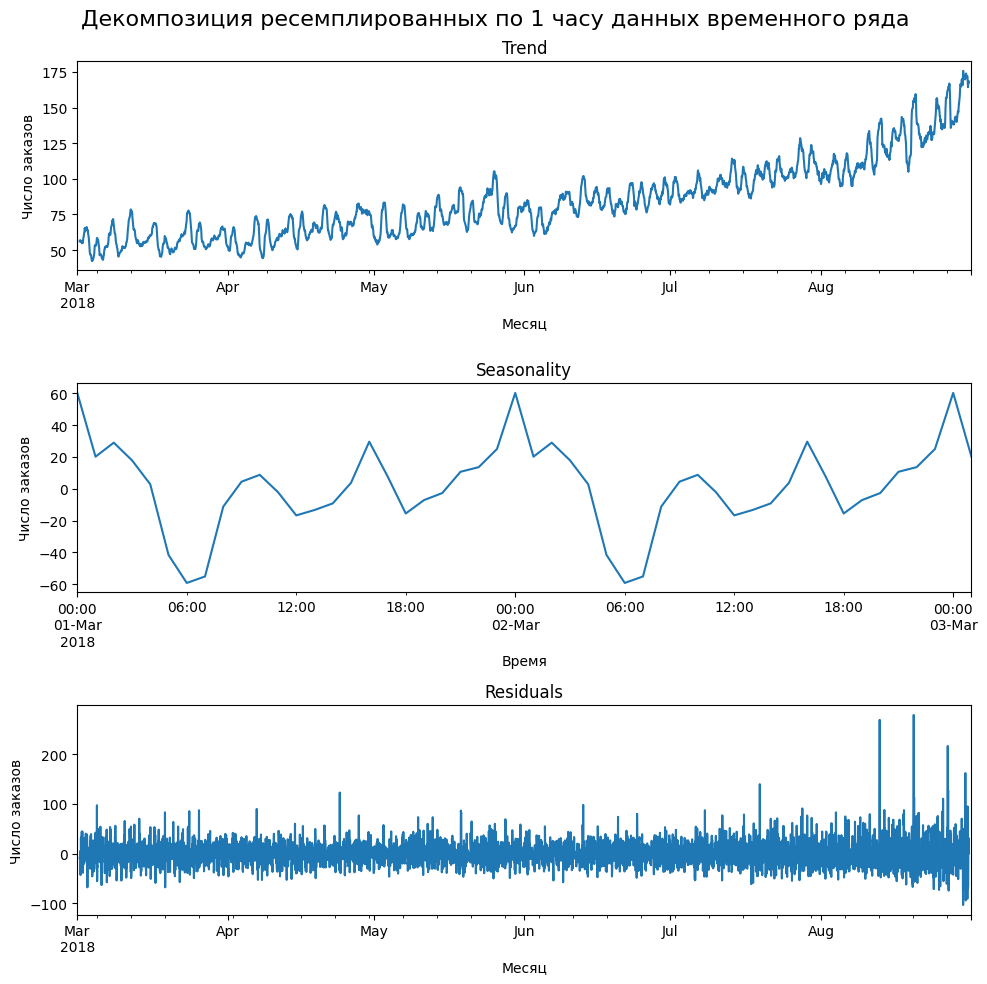

In [10]:
df1h = df.resample('1h').sum()
decomposed = seasonal_decompose(df1h)
plt.figure(figsize=(10, 10))
plt.suptitle('Декомпозиция ресемплированных по 1 часу данных временного ряда', fontsize=16)
plt.subplot(311)
# Чтобы график корректно отобразился, указываем его
# оси ax, равными plt.gca() (англ. get current axis,
# получить текущие оси)
decomposed.trend.plot(ax=plt.gca(), xlabel='Месяц', ylabel='Число заказов')
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal[:50].plot(ax=plt.gca(), xlabel='Время', ylabel='Число заказов') 
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca(), xlabel='Месяц', ylabel='Число заказов')
plt.title('Residuals')
plt.tight_layout()

Виден восходящий тренд с марта по август. Показатель сезонности суточной показывает активность в течение суток - рост с утра до ночи, с падением с 0 до 6.00, с 11 до 12 и с 17 до 18.00. Поскольку исследуются данные о вызовах такси в аэропорт, природа сезонности связана с расписанием прилета и вылета самолетов, пиковые значения могут коррелировать с времением прилета самолетов.

Так же дополнительно оценим стационарность ряда. Этот показатель хорошо иллюстрирует сглаженное среднее.

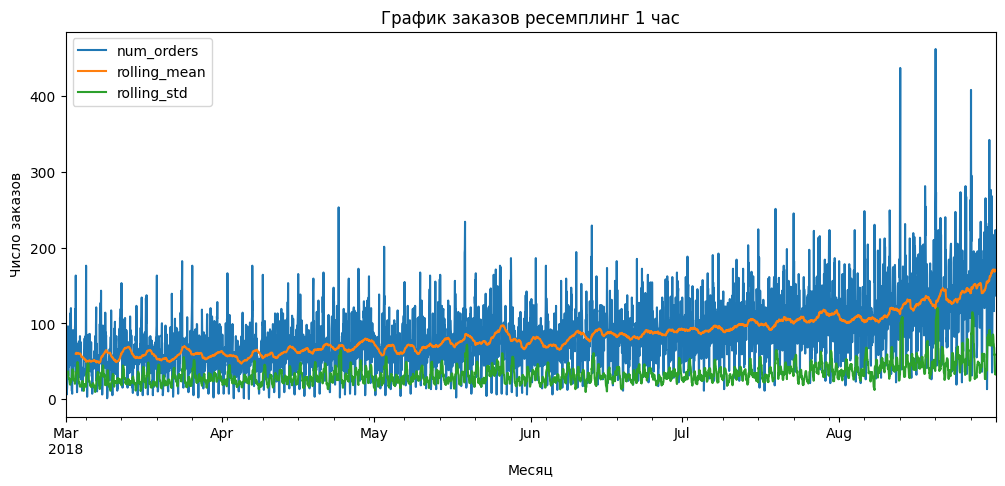

In [11]:
df1h['rolling_mean'] = df1h.shift().rolling(48).mean()
df1h['rolling_std'] = df1h.num_orders.shift().rolling(12).std()


df1h.plot(title='График заказов ресемплинг 1 час', xlabel='Месяц', ylabel='Число заказов');
# df1h.plot();

На графике видно плавное увеличение скользящего среднего. Сделовательно можно сделать вывод, что ряд не стационарный. Будем учитывать это при оставлении прогноза. Дополним исследование тестом Дики-Фуллера на стационарность ряда.

Формируем нелевую и альтернативную гипотезы. Уровень значимости теста примем равным альфа=0.01.
- H0 - временной ряд является не стационарным.
- H1 - временной ряд является стационарным.

In [12]:
alpha = 0.01
p_value = adfuller(df1h['num_orders'])[1]
print(p_value)
if p_value < alpha:
    print('Отвергаем H0')
else:
    print('Нельзя отвергнуть H0')

0.0289400514026128
Нельзя отвергнуть H0


Вывод: Нельзя отвергнуть нелевую гипотезу о нестационарности временного ряда c достоверностью 99%. Другими словами - ряд не стационарный.

Добавим в дататфрейм дополнительные признаки с помощью функции. Но прежде сделаем копию исходных данных. А так же используем функцию для оптимизации расода памяти.


In [13]:
df_new = df.copy()

In [14]:
# Оптимизация числовых типов данных
def optimize_memory_usage(df: pd.DataFrame, print_size: bool=True) -> pd.DataFrame:
    '''
    Function optimizes memory usage in dataframe
    df: pd.DataFrame - data table
    print_size: bool - display of optimization results
    return pd.DataFrame - amount of optimized memory
    '''
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64'] # Типы, которые будем проверять на оптимизацию
    # Размер занимаемой памяти до оптимизации (в Мб)
    before_size = df.memory_usage().sum() / 1024**2    
    for column in df.columns:
        column_type = df[column].dtypes
        if column_type in numerics:
            column_min = df[column].min()
            column_max = df[column].max()
            if str(column_type).startswith('int'):
                if column_min > np.iinfo(np.int8).min and column_max < np.iinfo(np.int8).max:
                    df[column] = df[column].astype(np.int8)
                elif column_min > np.iinfo(np.int16).min and column_max < np.iinfo(np.int16).max:
                    df[column] = df[column].astype(np.int16)
                elif column_min > np.iinfo(np.int32).min and column_max < np.iinfo(np.int32).max:
                    df[column] = df[column].astype(np.int32)
                elif column_min > np.iinfo(np.int64).min and column_max < np.iinfo(np.int64).max:
                    df[column] = df[column].astype(np.int64)  
            else:
                if column_min > np.finfo(np.float32).min and column_max < np.finfo(np.float32).max:
                    df[column] = df[column].astype(np.float32)
                else:
                    df[column] = df[column].astype(np.float64)    
    # Размер занимаемой памяти после оптимизации (в Мб)
    after_size = df.memory_usage().sum() / 1024**2
    if print_size: print('Размер использования памяти: до {:5.2f} Mb - после {:5.2f} Mb ({:.1f}%)'
                         .format(before_size, after_size, 100 * (before_size - after_size) / before_size))
    return df

In [15]:
df_new = optimize_memory_usage(df_new)

Размер использования памяти: до  0.40 Mb - после  0.23 Mb (43.8%)


Ресемплируем и делаем функцию для добавления новых прихнаков.

In [16]:
df_new  = df_new.resample('1h').sum()

In [17]:
def make_features(df, max_lag, rolling_mean_size):
    '''
    Добавление новых признаков в датафрейм на основе временного ряда в индексном столбце.
    '''
    data = df.copy()
#     data['month'] = data.index.month
    data['day'] = data.index.day
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
        
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data

В связи с суточным циклическим характером распределения добвим в функцию данные по каждому часу за последние 24 часа. У нас три пика это утром, в обед и вечером в 10 утра, 16.00 и в 0.00. Среднее скользящее логично будет взять меньше 6 часов, иначе среднее не будет отражать пиковые изменения. Возьмем среднее скользящее за 3 часа. 

In [18]:
data = make_features(df_new, 24, 3)
data = data.dropna() #Удаляем пропуски в начале
data.head()

,num_orders,day,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-03-02 00:00:00,90,2,0,4,58.00,113.00,66.00,61.00,45.00,73.00,44.00,43.00,66.00,48.00,32.00,30.00,96.00,64.00,69.00,34.00,15.00,12.00,6.00,43.00,66.00,71.00,85.00,124.00,79.00
2018-03-02 01:00:00,120,2,1,4,90.00,58.00,113.00,66.00,61.00,45.00,73.00,44.00,43.00,66.00,48.00,32.00,30.00,96.00,64.00,69.00,34.00,15.00,12.00,6.00,43.00,66.00,71.00,85.00,87.00
2018-03-02 02:00:00,75,2,2,4,120.00,90.00,58.00,113.00,66.00,61.00,45.00,73.00,44.00,43.00,66.00,48.00,32.00,30.00,96.00,64.00,69.00,34.00,15.00,12.00,6.00,43.00,66.00,71.00,89.33
2018-03-02 03:00:00,64,2,3,4,75.00,120.00,90.00,58.00,113.00,66.00,61.00,45.00,73.00,44.00,43.00,66.00,48.00,32.00,30.00,96.00,64.00,69.00,34.00,15.00,12.00,6.00,43.00,66.00,95.00
2018-03-02 04:00:00,20,2,4,4,64.00,75.00,120.00,90.00,58.00,113.00,66.00,61.00,45.00,73.00,44.00,43.00,66.00,48.00,32.00,30.00,96.00,64.00,69.00,34.00,15.00,12.00,6.00,43.00,86.33


Приведем дни недели в категориальные признаки.

In [19]:
data['dayofweek'] = data['dayofweek'].astype('category')
data['dayofweek'].dtype

CategoricalDtype(categories=[0, 1, 2, 3, 4, 5, 6], ordered=False, categories_dtype=int32)

## Создание модели

Будем подбирать модели предсказания с помощью пайплайна подбирая гиперпараметры моделей. Но сперва разбиваем данные на тренировочные и тестовые. 

In [20]:
train, test = train_test_split(data, test_size=0.1, shuffle=False)
train = train.dropna()
print(train.shape)
print(test.shape)
X_train = train.drop(['num_orders'], axis=1)
y_train = train['num_orders']
X_test = test.drop(['num_orders'], axis=1)
y_test= test['num_orders']
num_cols = X_train.select_dtypes(include='number').columns.tolist()
print(num_cols)
cat_cols = X_train.select_dtypes(exclude='number').columns.tolist()
print(cat_cols)

(3952, 29)
(440, 29)
['day', 'hour', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10', 'lag_11', 'lag_12', 'lag_13', 'lag_14', 'lag_15', 'lag_16', 'lag_17', 'lag_18', 'lag_19', 'lag_20', 'lag_21', 'lag_22', 'lag_23', 'lag_24', 'rolling_mean']
['dayofweek']


### Линейные модели

Готовим pipeline и настройки подбора гиперпараметров

In [21]:
pipe_num = Pipeline([
    ('imp_num', SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('scale', StandardScaler()),
])

pipe_cat = Pipeline([
    ('imp_cat_before', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ohe_enc', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)),
    ('imp_cat_after', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
])

In [22]:
linear_prep = ColumnTransformer([
    ('num', pipe_num, num_cols),
    ('cat', pipe_cat, cat_cols)
], remainder='passthrough')

lin_pipe = Pipeline([
    ('prep', linear_prep),
    ('model', Ridge(random_state=RANDOM_STATE))
])

In [23]:
param = [
    {
        'model': [Ridge(random_state=RANDOM_STATE)],
        'model__alpha': [0.1, 0.5, 1, 5, 10],
        'model__fit_intercept': [True, False],
        'prep__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'model': [LinearRegression()],
        'prep__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'model': [Lasso(random_state=RANDOM_STATE)],
        'model__alpha': [0.1, 0.5, 1, 5, 10],
        'prep__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
]

Для разбиения данные внутри кроссвалидации применим инструмент TimeSeriesSplit, который формирует фолды так, чтобы в фолдах для обучения не было данных из фолдов для тестирования, что критически важно при работе с временными рядами. 

In [24]:
tscv = TimeSeriesSplit(n_splits=5)

rand_search_linear = RandomizedSearchCV(
    lin_pipe, 
    param, 
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    random_state=RANDOM_STATE,
    n_iter=100
)

rand_search_linear.fit(X_train, y_train)
print('Лучшие параметры:', rand_search_linear.best_params_)
print ('RMSE на кроссвалидации:', -(rand_search_linear.best_score_))

Лучшие параметры: {'prep__num': MinMaxScaler(), 'model__fit_intercept': False, 'model__alpha': 1, 'model': Ridge(random_state=42)}
RMSE на кроссвалидации: 26.861697842010955


### Деревянные модели

In [25]:
pipe_num = Pipeline([
    ('imp_num', SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('scale', StandardScaler()),
])

pipe_cat = Pipeline([
    ('imp_cat_before', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ord_enc', OrdinalEncoder()),
    ('imp_cat_after', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
])

pipe_prep = ColumnTransformer([
    ('num', pipe_num, num_cols),
    ('cat', pipe_cat, cat_cols),
], remainder='passthrough')

pipe_tree = Pipeline([
    ('prep', pipe_prep),
    ('model', DecisionTreeRegressor(random_state=RANDOM_STATE))
])

param = [
    {
    'model': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
    'model__max_depth': range(1, 12),
    'model__min_samples_split': range(1,12),
    'model__min_samples_leaf': range(1,12),
    'model__max_features': range(1, 12),
    'prep': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
    'model': [RandomForestRegressor(random_state=RANDOM_STATE)],
    'model__max_depth': range(2, 25, 1),
    'model__max_features': range(2, 5),
    'prep': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
]

In [26]:
rand_search_tree = RandomizedSearchCV(
    lin_pipe, 
    param, 
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    random_state=RANDOM_STATE,
    n_iter=40
)

rand_search_tree.fit(X_train, y_train)
print('Лучшие параметры:', rand_search_tree.best_params_)
print ('RMSE на кроссвалидации:', -(rand_search_tree.best_score_))

Лучшие параметры: {'prep': 'passthrough', 'model__min_samples_split': 6, 'model__min_samples_leaf': 11, 'model__max_features': 9, 'model__max_depth': 10, 'model': DecisionTreeRegressor(random_state=42)}
RMSE на кроссвалидации: 29.77401346627131


### Бустинговая модель

In [32]:
lgbm_model = LGBMRegressor(categorical_feature=cat_cols, random_state=RANDOM_STATE)

lgbm_param = {
    'boosting_type': ['gbdt', 'dart'],
    'max_depth': [-1, 5],
    'learning_rate': [0.1, 1]
}

grid_search_lgbm = GridSearchCV(
    estimator=lgbm_model,
    param_grid=lgbm_param,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search_lgbm.fit(X_train, y_train)
print('Лучшие параметры:', grid_search_lgbm.best_params_)
print('RMSE на кроссвалидации:', -grid_search_lgbm.best_score_)

[LightGBM] [Warning] categorical_feature is set=dayofweek, categorical_column=2 will be ignored. Current value: categorical_feature=dayofweek
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001220 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4871
[LightGBM] [Info] Number of data points in the train set: 3952, number of used features: 28
[LightGBM] [Info] Start training from score 78.451417
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

## Тестирование

Поскольку лучшую метрику показала бустинговая модель - берем ее на тестирование.

In [28]:
print('Лучшая модель: RMSE на тестовой выборке: ', mean_squared_error(y_test, grid_search_lgbm.predict(X_test), squared=False).round(2))
grid_search_lgbm.best_params_

Лучшая модель: RMSE на тестовой выборке:  39.86


{'boosting_type': 'gbdt', 'learning_rate': 0.1, 'max_depth': 5}

Вывод. Показатель RMSE укладывается в допустимую норму - меньше 48. 
Можно использовать для предсказаний модель LGBMRegressor() с параметрами:
{'boosting_type': 'gbdt', 'learning_rate': 0.1, 'max_depth': 5}

Проверим лучшую модель на адекватность, сравним качество ее предсказаний с с качеством модели, которая предсказывала бы константу. В качестве константной модели используем DummyRegressor.

In [29]:
pipe_num = Pipeline([
    ('imp_num', SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('scale', StandardScaler()),
])

pipe_cat = Pipeline([
    ('imp_cat_before', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ord_enc', OrdinalEncoder()),
    ('imp_cat_after', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
])

pipe_prep = ColumnTransformer([
    ('num', pipe_num, num_cols),
    ('cat', pipe_cat, cat_cols),
], remainder='passthrough')

pipe_dummy = Pipeline([
    ('prep', pipe_prep),
    ('model', DummyRegressor())
])

pipe_dummy.fit(X_train, y_train)
print('RMSE на тестовой выборке: ', mean_squared_error(y_test, pipe_dummy.predict(X_test), squared=False).round(2))

RMSE на тестовой выборке:  84.69


DummyModel проиграла со счетом 84.69 : 39.86.

Для наглядности визуализируем предстказания лучшей модели и наложим их на правильные ответы в режиме линеного графика.

In [30]:
pred_dummy_series = pd.Series(pipe_dummy.predict(X_test))
pred_dummy_series.index = X_test.index
pred_lgbm_series = pd.Series(grid_search_lgbm.predict(X_test))
pred_lgbm_series.index = X_test.index

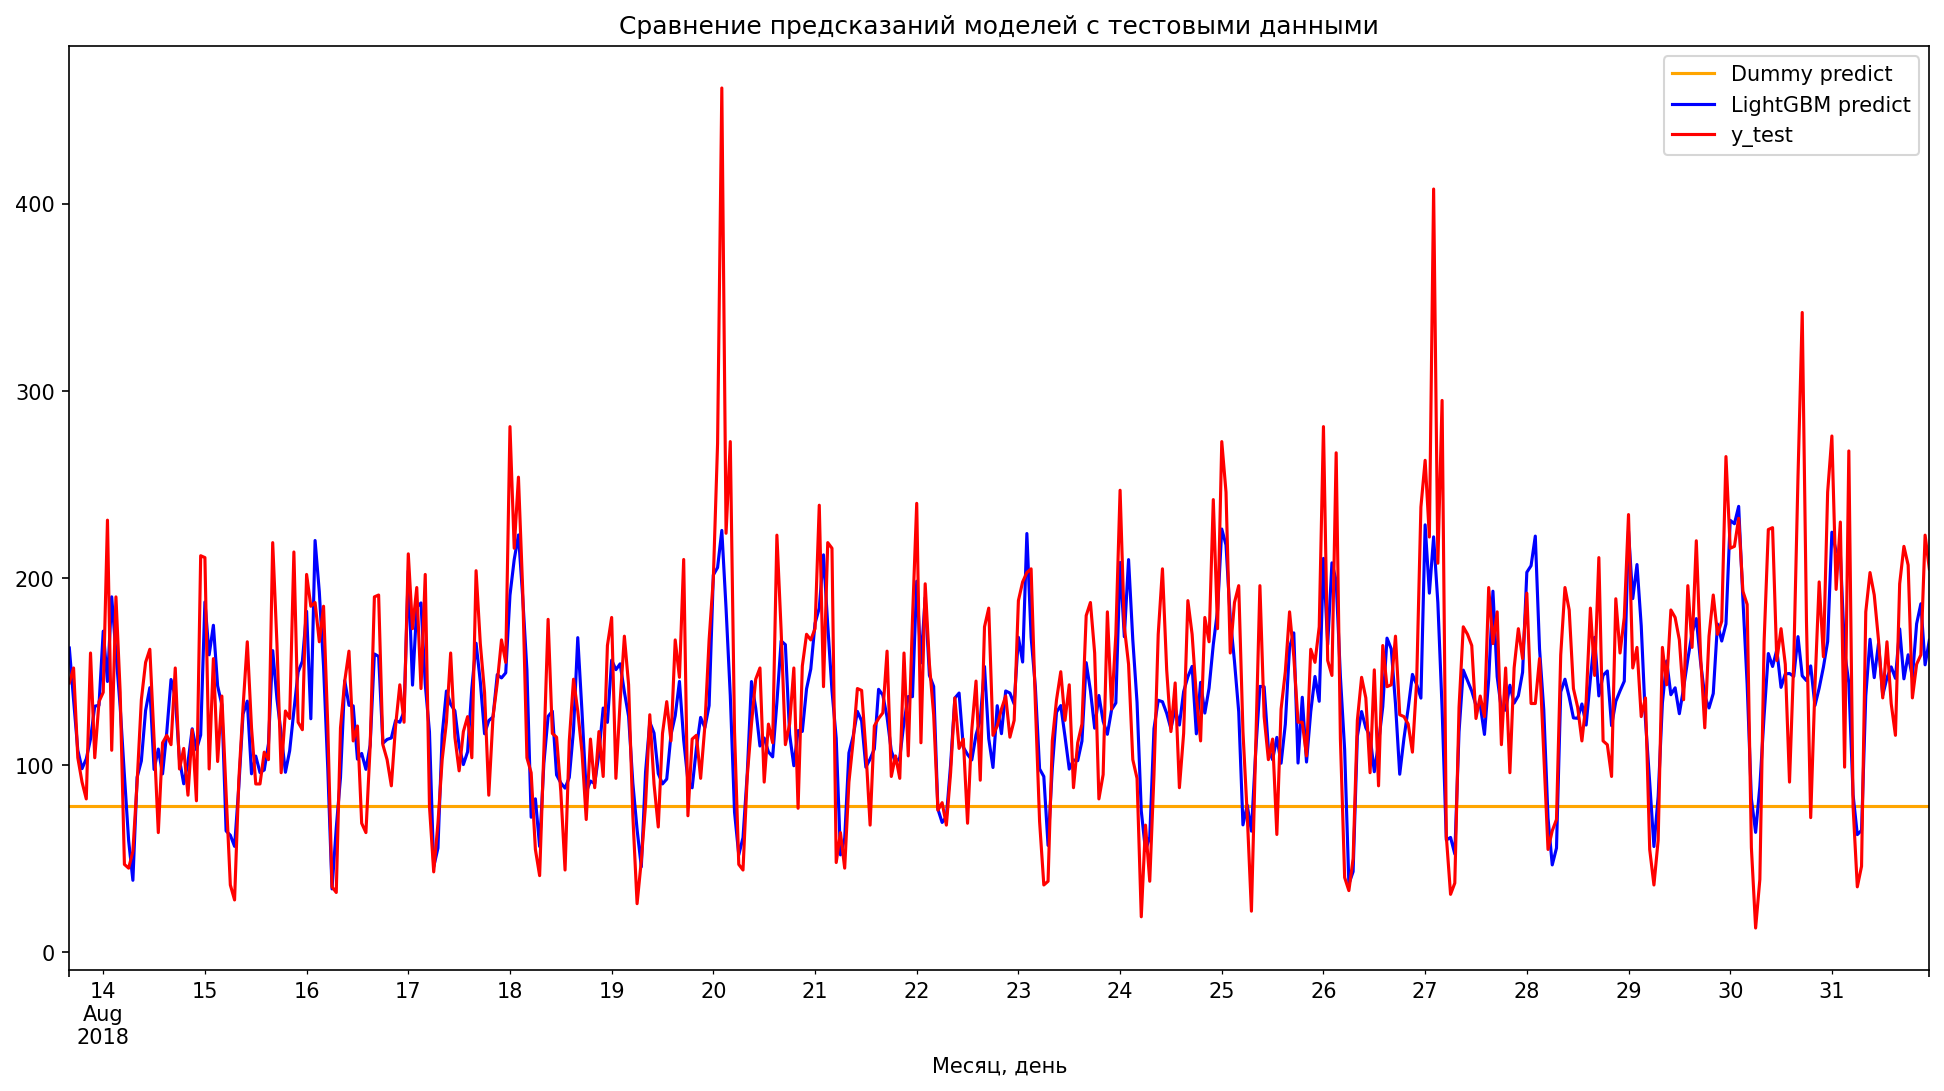

In [31]:
plt.figure(figsize=(16, 8), dpi=150) 
  
pred_dummy_series.plot(label='Dummy predict', color='orange') 
pred_lgbm_series.plot(label='LightGBM predict', color='blue') 
y_test.plot(label='y_test', color='red') 
plt.title('Сравнение предсказаний моделей с тестовыми данными') 
plt.xlabel('Месяц, день') 
plt.legend() ;

## Вывод
Были проанализированые поступившие данные. Данные предоставлены за период с 1 марта по 31 августа 2018 года. Виден восходящий тренд с марта по август. Показатель сезонности суточной показывает активность в течение суток - рост с утра до ночи, с падением с 0 до 6.00, с 11 до 12 и с 17 до 18.00.
С помощью бустинговой модели LGBMRegressor с параметрами {'boosting_type': 'gbdt', 'learning_rate': 0.1, 'max_depth': 5} получили показатель RMSE на тестовой выборке: 39.86, что укладывается в заданные параметры.